[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY") #Not used

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True) #path to my env folder

True

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: float, b: float) -> float:
    """Divide a by b.
    Args:
        a: numerator
        b: denominator
    """
    if b == 0:
        return "Error: Cannot divide by zero"
    return a / b

def add(a: int, b: int) -> int:
    """Add a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.
    Args:
        a: first int
        b: second int
    """
    return a - b

def square(a: float) -> float:
    """Calculate the square of a number (a²).
    
    Args:
        a: the number to square
    """
    return a ** 2

def square_root(a: float) -> float:
    """Calculate the square root of a number (√a).
    
    Args:
        a: the number to find square root of (must be non-negative)
    """
    import math
    if a < 0:
        return "Error: Cannot calculate square root of negative number"
    return math.sqrt(a)

def modulo(a: int, b: int) -> int:
    """Calculate the remainder when a is divided by b (a % b).
    
    Args:
        a: the dividend
        b: the divisor
    """
    if b == 0:
        return "Error: Cannot divide by zero"
    return a % b

def get_current_time() -> str:
    """Get the current date and time.
    No arguments needed.
    """
    from datetime import datetime
    return datetime.now()

def get_weather(location: str) -> str:
    """Get the current weather for a location.
    Args:
        location: city name or location 
    """
    import requests
    
    # Using Open-Meteo API 
    
    geocoding_url = f"https://geocoding-api.open-meteo.com/v1/search?name={location}&count=1&language=en&format=json"
    
    try:
        geo_response = requests.get(geocoding_url)
        geo_data = geo_response.json()
        
        if not geo_data.get("results"):
            return f"Location '{location}' not found"
        
        lat = geo_data["results"][0]["latitude"]
        lon = geo_data["results"][0]["longitude"]
        city_name = geo_data["results"][0]["name"]
        
        # Get weather data
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code&temperature_unit=celsius"
        weather_response = requests.get(weather_url)
        weather_data = weather_response.json()
        
        temp = weather_data["current"]["temperature_2m"]
        
        return f"Current weather in {city_name}: {temp}°C"
    
    except Exception as e:
        return f"Error getting weather: {str(e)}"

# Bind all tools to the LLM

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)
tools=[multiply, divide, add, subtract, square, square_root, modulo, get_current_time, get_weather]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!


Let's create our LLM and prompt it with the overall desired agent behavior.

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with two seperate things depending on user input, 1. if user input is relating to arithemetic and/or numerical, then you are tasked with performing arithmetic on a set of inputs. 2. if user input is location/date/time based, then you are tasked with fetching environmental information such as curent date, time, and weather in user specified locations")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

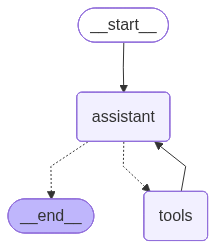

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
messages = [HumanMessage(content="""Add 10 and 49. Multiply the output by 2. Divide the output by 5. Square the output.
             Get modulo of output by 2. Add 89 to output. Find the square root of the output. Subtract the output by 2""")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 49. Multiply the output by 2. Divide the output by 5. Square the output.
             Get modulo of output by 2. Add 89 to output. Find the square root of the output. Subtract the output by 2
================================== Ai Message ==================================
Tool Calls:
  add (cfb7b1df-5a9b-440f-b69d-122ce65fa2dd)
 Call ID: cfb7b1df-5a9b-440f-b69d-122ce65fa2dd
  Args:
    b: 49
    a: 10
================================= Tool Message =================================
Name: add

59
================================== Ai Message ==================================
Tool Calls:
  multiply (bf0f5ebe-7523-4e6c-97a6-d58c3a1d3e84)
 Call ID: bf0f5ebe-7523-4e6c-97a6-d58c3a1d3e84
  Args:
    b: 2
    a: 59
================================= Tool Message =================================
Name: multiply

118
================================== Ai Message ==================================
Tool Cal

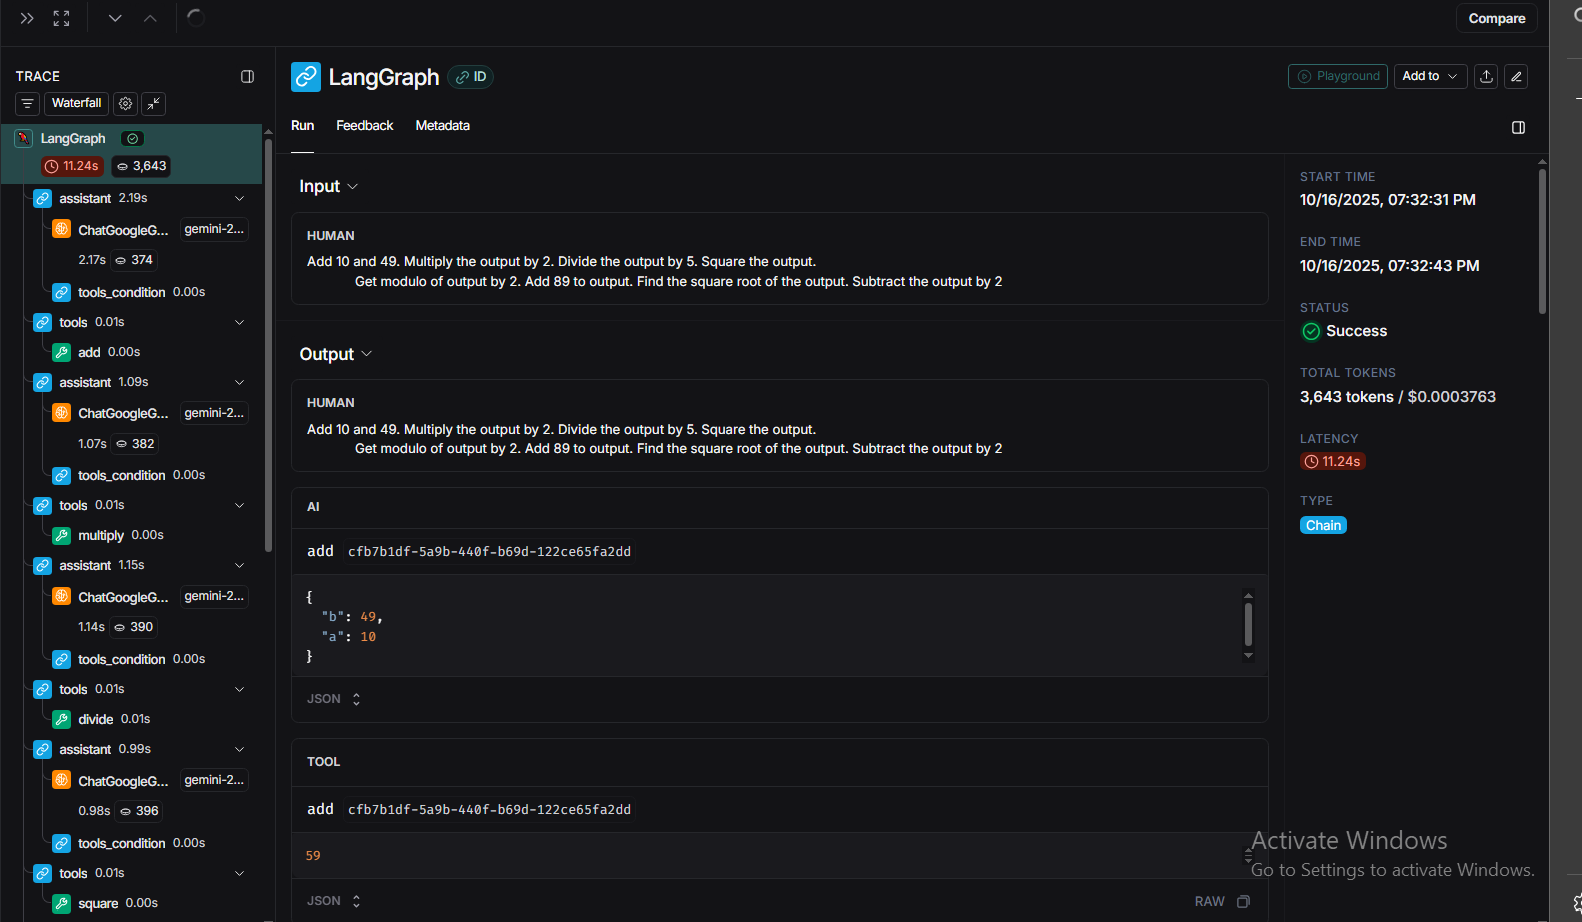
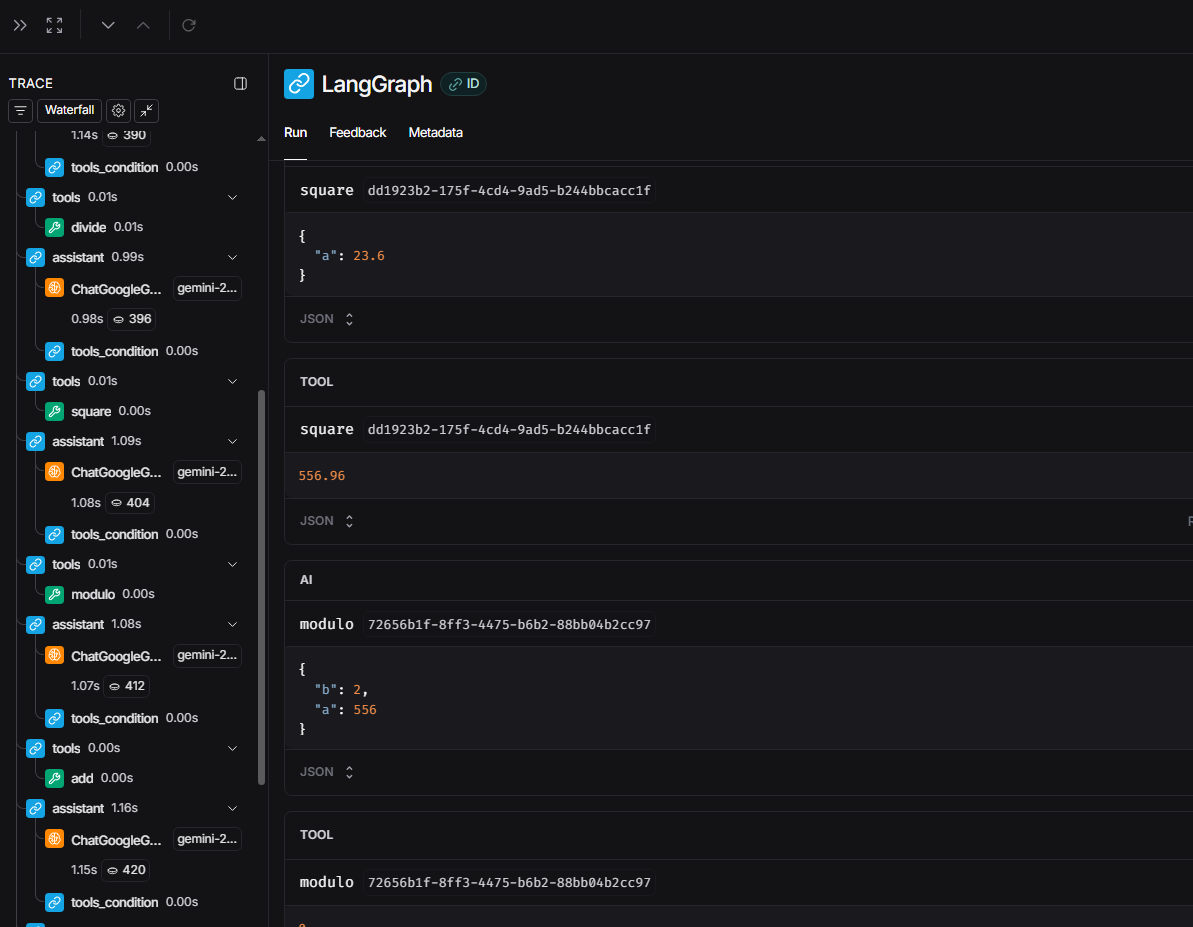

In [13]:
messages = [HumanMessage(content="""Find current date and time. Find weather in delhi, then find weather in Cambodia, then find weather in dubai""")]
messages = react_graph.invoke({"messages": messages})

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find current date and time. Find weather in delhi, then find weather in Cambodia, then find weather in dubai
================================== Ai Message ==================================
Tool Calls:
  get_current_time (bdb3916e-16a7-4414-a68c-1c210df514a6)
 Call ID: bdb3916e-16a7-4414-a68c-1c210df514a6
  Args:
  get_weather (d99d4c4d-a064-41d7-aae9-6c86980fb13a)
 Call ID: d99d4c4d-a064-41d7-aae9-6c86980fb13a
  Args:
    location: delhi
  get_weather (777cff14-7766-4997-957b-a44b5d10bf5e)
 Call ID: 777cff14-7766-4997-957b-a44b5d10bf5e
  Args:
    location: Cambodia
  get_weather (a6844b8f-c90f-4c15-b553-7c34bdd2405a)
 Call ID: a6844b8f-c90f-4c15-b553-7c34bdd2405a
  Args:
    location: dubai
================================= Tool Message =================================
Name: get_current_time

2025-10-16 19:40:21.643247
================================= Tool Message =================================
Nam

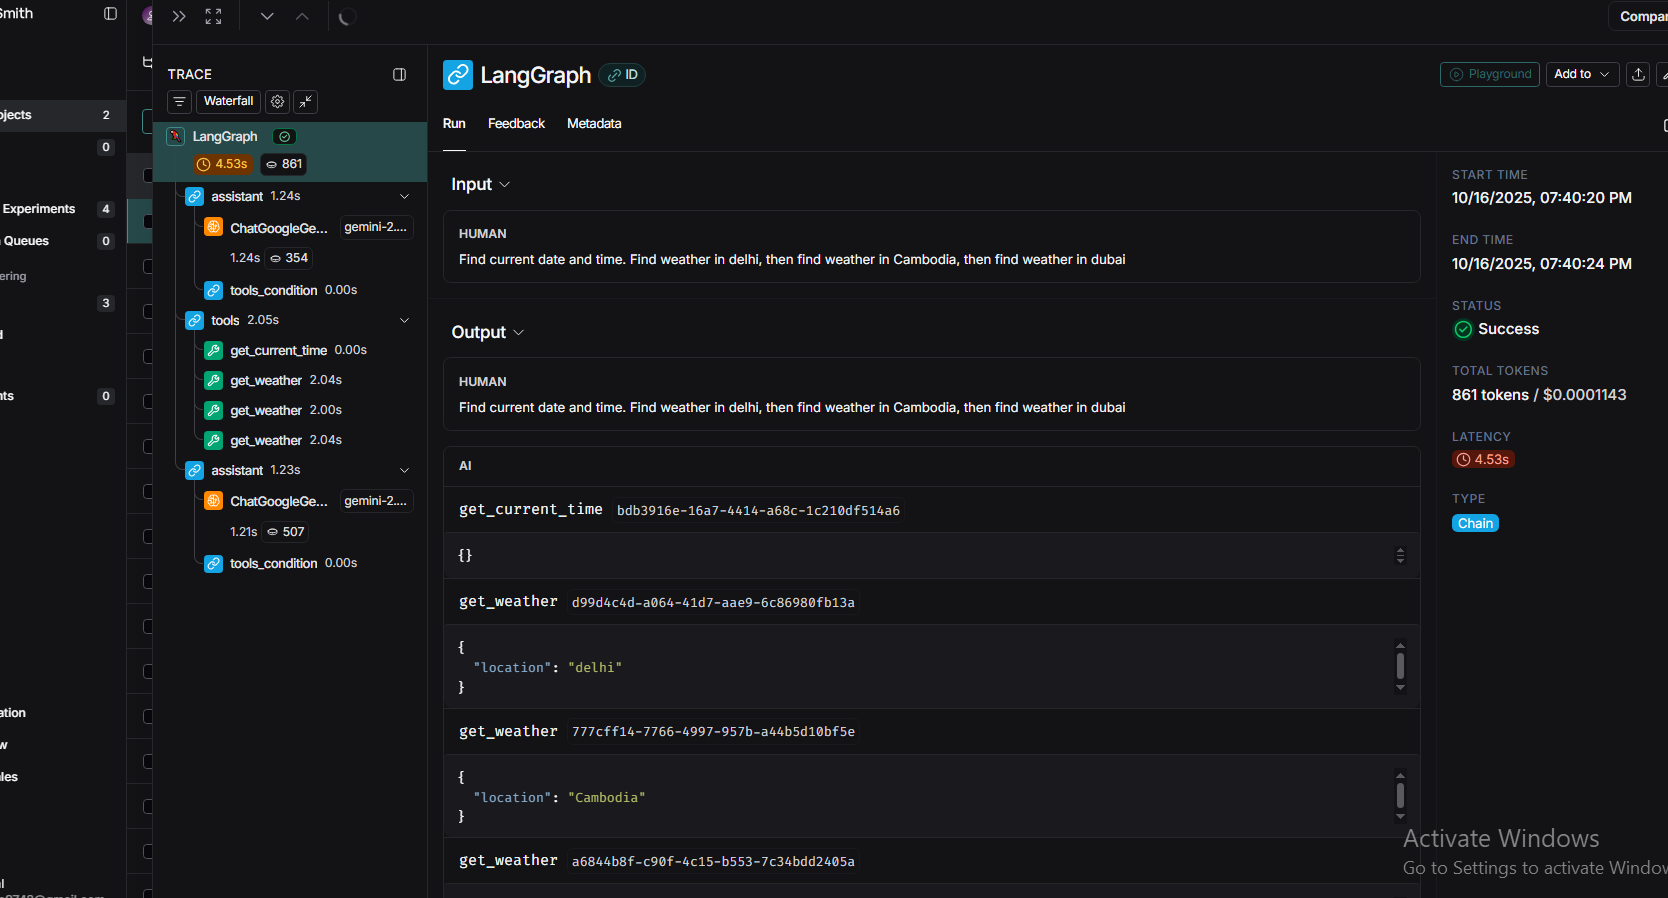
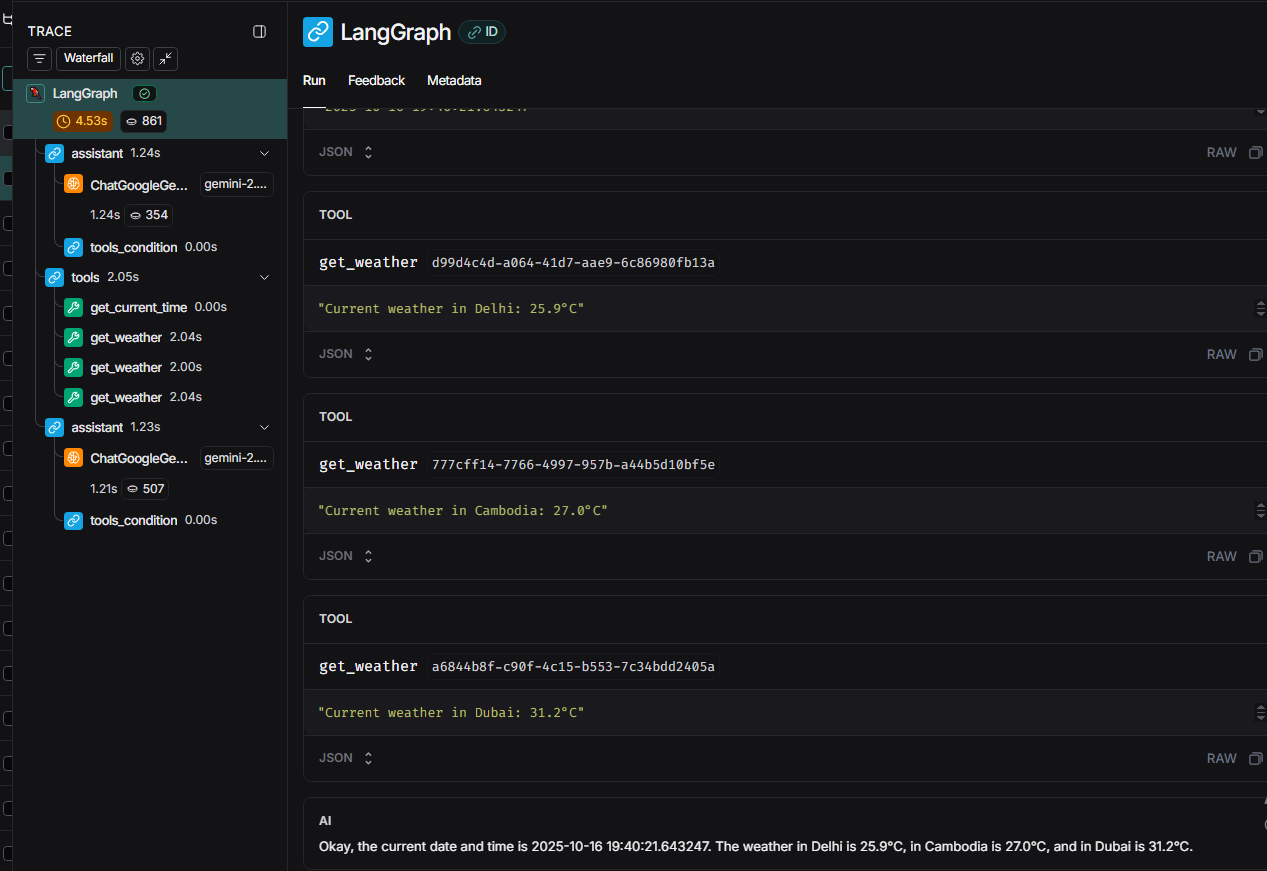

In [ ]:
#THE TWO SCREENSHOTS SHOWCASE LANGSMITH TRACES FOR THE TWO QUERIES, EACH WITH MULTIPLE CONSECUTIVE TOOL CALLS

## LangSmith

We can look at traces in LangSmith.